In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import math

In [3]:
%matplotlib inline
import ternary

In [4]:
def sigmoid(x,centre,sharpness):
    return np.exp(sharpness*(x-centre))/(1+np.exp(sharpness*(x-centre)))

In [5]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)

In [6]:
def colour_points(points,alpha):
    # assumes points sum to 1 row-wise
    colours = []
    for i in points:
        colours.append((i[0],i[1],i[2],alpha))
    return colours

In [7]:
def corner_colours(x,y,z,centre,sharpness):
    x_color = sigmoid(x,centre,sharpness)
    y_color = sigmoid(y,centre,sharpness)
    z_color = sigmoid(z,centre,sharpness)
    return (x_color, y_color, z_color, 1.)

In [8]:
def generate_heatmap_data(scale, resolution=2):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale*resolution):
        d[(i/resolution, j/resolution, k/resolution)] = color_point(i/resolution, j/resolution, k/resolution, scale)
    return d

In [9]:
# Make images higher resolution and set default size
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams['figure.facecolor'] = '1.0'
import matplotlib.pyplot as plt

In [10]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)

In [11]:
a = 0.05
t = np.arange(-20,15,0.05)
x = np.exp(np.cos(t) / np.sqrt(1+a*a*t*t))
y = np.exp(np.sin(t) / np.sqrt(1+a*a*t*t))
z = np.exp(- a*t / np.sqrt(1+a*a*t*t))
m = x + y + z
points = np.stack((x/m, y/m, z/m), axis = 1)

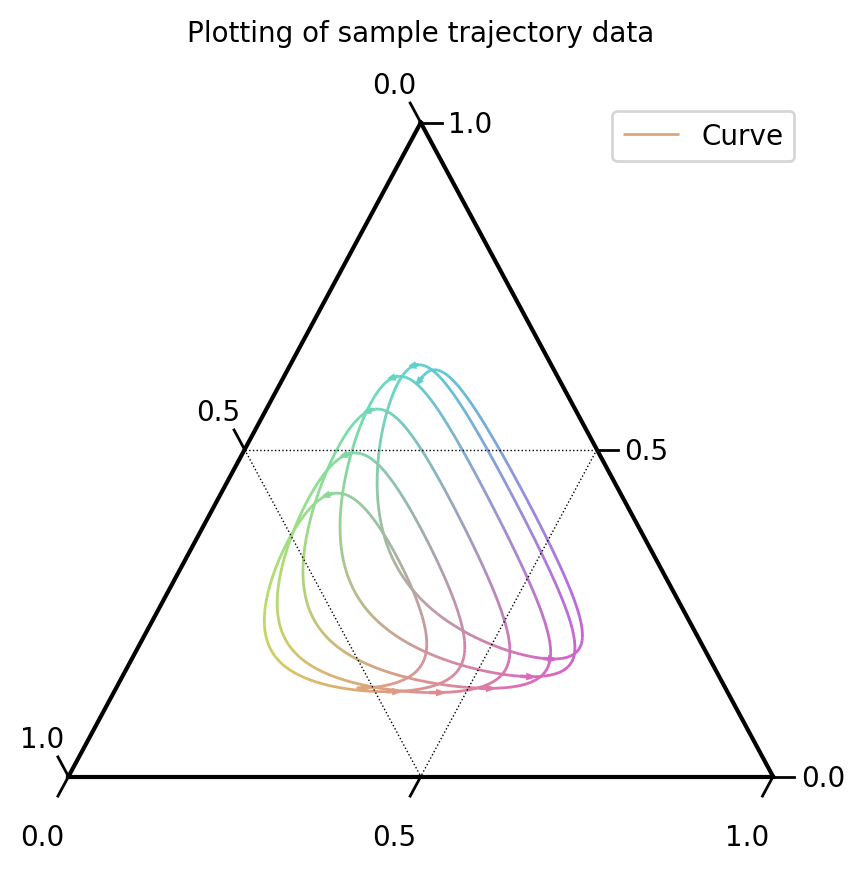

In [14]:
## Sample trajectory plot
figure, tax = ternary.figure(scale=1)
figure.set_size_inches(5, 5)

tax.boundary()
tax.gridlines(multiple=1./2, color="black")
tax.set_title("Plotting of sample trajectory data", fontsize=10, pad=20)

#tax.plot_colored_trajectory(points, cmap="hsv", linewidth=1.0, label="Mix")
tax.new_colored_trajectory(points, linewidth=1.0, label="Curve")
tax.arrow(points, arrows=10, start=True, end=True, lw=1., head_width=0.005)
tax.ticks(axis='lbr', multiple=1./2, linewidth=1, tick_formats="%.1f", offset=0.03)

tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()

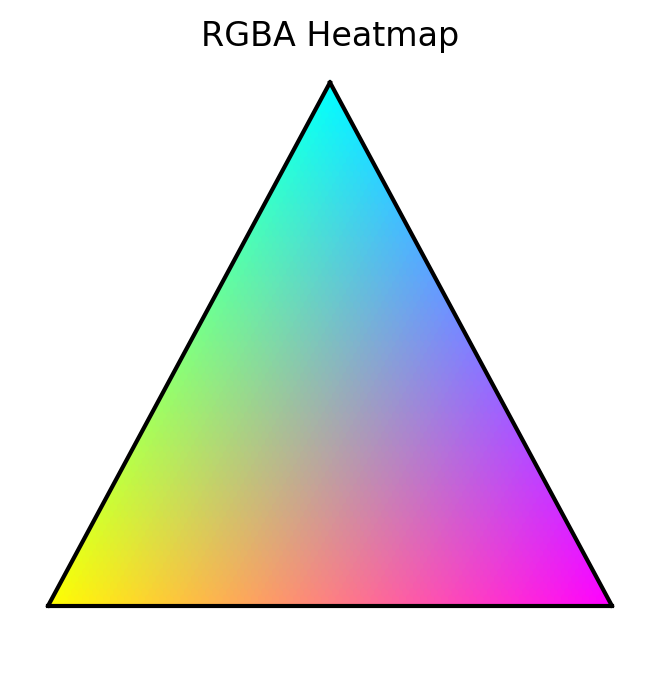

In [13]:
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(w - y_color) / w
    g = math.fabs(w - x_color) / w
    b = math.fabs(w - z_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

scale = 80
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
plt.show()